#K means with PSO

Below is the code for the kmedian facility location problem with added constraints like forbidden location and the minimum demand. PSO is used to solve this problem

The **Particle Swarm Optimization (PSO)** algorithm is a computational technique **inspired** by the collective behavior of natural organisms, such as **birds ** or **fish**, that move together to achieve a common goal. In PSO, a **group of particles** (representing potential solutions) navigates through a problem’s solution space to find the best possible solution. Each particle adjusts its position based on its own best-known solution (personal best) and the best solution discovered by the entire group (global best). This collaborative movement enables particles to converge toward optimal solutions over iterations. PSO is widely used for optimization problems in various fields, leveraging the power of collective intelligence to explore complex solution spaces and find optimal outcomes efficiently.

In [ ]:
pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 19.0 MB/s eta 0:00:00


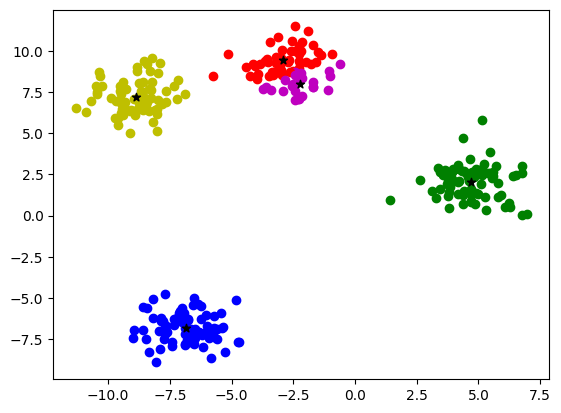

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.spatial.distance import cdist
import random

class KMeansPSO:
    def __init__(self, w, c1, c2, max_iter, tau, X, n_clusters, forbidden_locations):
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.max_iter = max_iter
        self.tau = tau
        self.X = X
        self.n_clusters = n_clusters
        self.forbidden_locations = forbidden_locations
        self.forbidden_locations_array = np.array(forbidden_locations)
        self.penalty = 1e6  # Large penalty value

    # Define the fitness function for PSO with penalty
    def fitness(self, X, centroids, labels):
        # Calculate the sum of squared distances
        total_distance = np.sum([np.linalg.norm(X[i] - centroids[labels[i]]) for i in range(len(X))])

        # Add penalty for forbidden locations
        forbidden_set = set(map(tuple, self.forbidden_locations))
        for centroid in centroids:
            if tuple(centroid) in forbidden_set:
                total_distance += self.penalty

        # Add penalty for clusters with fewer than tau points
        cluster_sizes = np.bincount(labels, minlength=self.n_clusters)
        total_distance += np.sum([self.penalty for size in cluster_sizes if size < self.tau])

        return total_distance

    # Initialize the particles (centroids) and velocities randomly
    def initialize_particles(self, X, n_clusters, n_features):
        np.random.seed(42)
        particles = np.random.rand(n_clusters, n_features) * (X.max(axis=0) - X.min(axis=0)) + X.min(axis=0)
        velocities = np.zeros((n_clusters, n_features))
        return particles, velocities

    # Update velocity and position for PSO
    def update_velocity_position(self, particles, velocities, p_best, g_best, w, c1, c2):
        for i in range(len(particles)):
            random.seed(42)
            r1 = random.random()
            random.seed(42)
            r2 = random.random()
            velocities[i] = w * velocities[i] + c1 * r1 * (p_best[i] - particles[i]) + c2 * r2 * (g_best - particles[i])
            particles[i] = particles[i] + velocities[i]
        return particles, velocities

    # Update centroids based on assignments
    def update_centroid(self, X, labels, n_clusters):
        centroids = np.zeros((n_clusters, X.shape[1]))
        for i in range(n_clusters):
            points = X[labels == i]
            if len(points) > 0:
                centroids[i] = points.mean(axis=0)
        return centroids

    # Check for forbidden locations
    def check_forbidden_locations(self, centroids, forbidden_locations):
        forbidden_set = set(map(tuple, forbidden_locations))  # Convert forbidden locations to a set of tuples for faster lookup
        new_centroids = centroids.copy()
        for i, centroid in enumerate(centroids):
            if tuple(centroid) in forbidden_set:
                # Reinitialize the centroid if it's in a forbidden location
                new_centroid = np.random.rand(centroids.shape[1])
                while tuple(new_centroid) in forbidden_set:
                    new_centroid = np.random.rand(centroids.shape[1])
                new_centroids[i] = new_centroid
        return new_centroids

    # K-means clustering with PSO and additional constraints
    def constrained_kmeans_pso(self, X, n_clusters, max_iter, tau, forbidden_locations):
        n_features = X.shape[1]

        # Initialize particles (centroids) and velocities
        particles, velocities = self.initialize_particles(X, n_clusters, n_features)
        p_best = particles.copy()
        g_best = particles[np.argmin([self.fitness(X, particles, np.argmin(cdist(X, particles), axis=1)) for p in particles])]

        for iteration in range(max_iter):
            # E-step: Assign points to the nearest centroid
            labels = np.argmin(cdist(X, particles), axis=1)

            # Calculate fitness
            current_fitness = self.fitness(X, particles, labels)

            # Update personal best
            for i in range(n_clusters):
                if self.fitness(X, particles, labels) < self.fitness(X, p_best, labels):
                    p_best[i] = particles[i]

            # Update global best
            g_best = p_best[np.argmin([self.fitness(X, p_best, labels) for _ in range(n_clusters)])]

            # Update velocity and position using PSO
            particles, velocities = self.update_velocity_position(particles, velocities, p_best, g_best, self.w, self.c1, self.c2)

            # Update centroids
            new_particles = self.update_centroid(X, labels, n_clusters)

            # Check for forbidden locations
            new_particles = self.check_forbidden_locations(new_particles, forbidden_locations)

            # Check if centroids have changed significantly
            if np.allclose(new_particles, particles, atol=1e-4):
                break

            particles = new_particles

        particles = self.check_forbidden_locations(particles)
        labels = np.argmin(cdist(X, particles), axis=1)
        return particles, labels

# Example usage
X1, _ = make_blobs(n_samples=300, centers=4, n_features=2, random_state=42)  # this is a 2D array
forbidden_locations = [(1.0, 1.0), (-8.87357218,  7.17458342)]  # , (-2.16539536, 5.27894805)
model = KMeansPSO(w=0.5, c1=1.5, c2=1.5, max_iter=1000, tau=20, n_clusters=5, X=X1, forbidden_locations=forbidden_locations)

# Parameters
n_clusters = 5
tau = 20

centroid, labels = model.constrained_kmeans_pso(X1, n_clusters, model.max_iter, tau, forbidden_locations)

for i in range(len(labels)):
    if labels[i] == 0:
        plt.scatter(X1[i][0], X1[i][1], marker='o', color='r')
    if labels[i] == 1:
        plt.scatter(X1[i][0], X1[i][1], marker='o', color='g')
    if labels[i] == 2:
        plt.scatter(X1[i][0], X1[i][1], marker='o', color='b')
    if labels[i] == 3:
        plt.scatter(X1[i][0], X1[i][1], marker='o', color='y')
    if labels[i] == 4:
        plt.scatter(X1[i][0], X1[i][1], marker='o', color='m')

plt.scatter(centroid[:, 0], centroid[:, 1], marker='*', color='black')
plt.show()


In [ ]:
centroid
# for cent in centroid:
#   tuple_cent = tuple(cent)
#   print(f"{tuple_cent[1]:.2f}")

array([[ 0.        ,  0.        ],
       [ 6.73771052, -5.77833986],
       [-6.38436959, -6.42630048],
       [-9.70279864,  9.47405888],
       [ 0.        ,  0.        ]])

In [ ]:
labels

array([1, 3, 2, 3, 3, 3, 3, 2, 2, 2, 2, 3, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 2, 1, 3, 1, 2, 2, 3, 3, 1, 1, 1, 2, 3, 1, 2, 3, 2, 1, 3, 1, 3,
       2, 2, 1, 2, 2, 3, 1, 1, 1, 2, 1, 1, 2, 2, 1, 3, 2, 2, 2, 3, 2, 3,
       2, 3, 2, 3, 1, 1, 1, 2, 2, 2, 3, 1, 2, 1, 1, 3, 1, 2, 1, 3, 1, 3,
       3, 1, 3, 2, 2, 2, 3, 1, 1, 2, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 1, 3,
       2, 2, 3, 3, 3, 2, 1, 3, 2, 3, 2, 2, 1, 3, 3, 3, 3, 1, 2, 2, 2, 3,
       2, 2, 3, 1, 2, 3, 3, 2, 3, 3, 3, 1, 1, 1, 3, 3, 2, 3, 3, 2, 3, 1,
       1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 1, 2, 3, 1, 2, 2, 3, 3, 3, 1, 1, 2,
       3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 1, 1, 1, 2, 3, 1, 1, 2, 3, 2, 1, 1,
       2, 1, 3, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 3, 2, 3, 3, 1, 1, 3, 1, 2,
       2, 1, 3, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 3, 1, 1,
       2, 1, 3, 3, 1, 3, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1,
       2, 1, 3, 2, 3, 3, 3, 2, 3, 1, 1, 2, 1, 1, 3, 3, 1, 1, 1, 2, 2, 2,
       3, 3, 2, 3, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2])

In [ ]:
np.unique(labels)

array([1, 2, 3])

In [ ]:
count = np.zeros(5)
for i in range(len(labels)):
   if labels[i] == 0:
     count[0] += 1
   elif labels[i] == 1:
     count[1] += 1
   elif labels[i] == 2:
     count[2] += 1
   elif labels[i] == 3:
     count[3] += 1
   elif labels[i] == 4:
     count[4] += 1

count

array([  0., 100., 100., 100.,   0.])

In [ ]:
centroid

array([[-8.00489101,  3.17314505],
       [-7.53128241,  7.98021992],
       [-8.47486329, -1.38236744],
       [-2.16539536,  5.27894805]])

#Constrained K-Means Clustering Algorithm

In this problem only one constraint is added in the kmeans algorithm. The cosntraint is of minimum demand. These type of constraints can be seen when k number of mobile tower is to be located in a particular region with satisfying atleast "m" user demand.

In [ ]:
pip install gurobipy

In [ ]:
from gurobipy import Model, GRB, quicksum  # Import Model, GRB, and quicksum from gurobipy
import numpy as np

def optimize_label(D, C, k, tau, mu=None):
    # Create a new model
    model = Model()  # Use Model() to create a model
    model.setParam('OutputFlag', 0)  # turn off Gurobi output

    # Create a vector of variables x
    m = D.shape[0]  # Number of demand points
    c = C.shape[0]  # Number of clusters (facility locations)
    vtype = GRB.BINARY  # Use GRB.BINARY for binary variables

    # Initialize T as a dictionary to store variables
    T = {}
    for i in range(m):
        for j in range(c):
            T[i, j] = model.addVar(vtype=vtype, name=f"T_{i}_{j}")

    # Add constraints
    # Each cluster should have at least tau demand points
    for j in range(c):
        model.addConstr(sum(T[i, j] for i in range(m)) >= tau, f"c0_{j}")

    # Each demand point must be assigned to exactly one cluster
    for i in range(m):
        model.addConstr(sum(T[i, j] for j in range(c)) == 1, f"c1_{i}")

    # Set the objective function
    obj = quicksum(
        T[i, j] * (1 / 2) * np.linalg.norm(D[i] - C[j])
        for i in range(m)
        for j in range(c)
    )
    model.setObjective(obj, GRB.MINIMIZE)

    # Optimize model
    model.optimize()

    # Retrieve the optimized values of the variables and reshape into matrix form
    T_values = np.array([T[i, j].X for i in range(m) for j in range(c)]).reshape(m, c)
    return T_values

# Example usage
D = np.array([[1, 2], [3, 4], [5, 6]])
C = np.array([[2, 3], [4, 5]])
k = 2
tau = 1

# This ia the matrix for T values which contain the value of T for each point  in the cluster
T_values = optimize_label(D, C, k, tau)
print(T_values)


[[1. 0.]
 [1. 0.]
 [0. 1.]]


In [ ]:
import numpy as np

def Update_Centroid(T, D, m, k, C):
    for i in range(k):
        cluster_sum = sum(T[j][i] for j in range(m))
        if cluster_sum > 0:
            num = sum(T[j][i] * D[j] for j in range(m))
            den = sum(T[j][i] for j in range(m))
            C[i] = num / den
        else:
            C[i] = C[i]
    return C


#long lat

#lat long to coordinate point

In [ ]:
import numpy as np

def latlon_to_xy(lat, lon, lat0, lon0):
    """
    Convert latitude and longitude to x, y coordinates using equirectangular projection.

    Parameters:
    lat (float): Latitude of the point to convert.
    lon (float): Longitude of the point to convert.
    lat0 (float): Reference latitude (origin).
    lon0 (float): Reference longitude (origin).

    Returns:
    x (float): x coordinate.
    y (float): y coordinate.
    """
    # Convert degrees to radians
    lat = np.radians(lat)
    lon = np.radians(lon)
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)

    # Radius of the Earth (in meters)
    R = 6371000

    # Compute x and y coordinates
    x = R * (lon - lon0) * np.cos((lat + lat0) / 2)
    y = R * (lat - lat0)

    return x, y

#generating the coordinates

In [ ]:
import numpy as np

# Coordinates of the cities
coordinates = [
    (34.0522, -118.2437),  # Los Angeles
    (41.8781, -87.6298),   # Chicago
    (29.7604, -95.3698),   # Houston
    (40.7128, -74.0060)    # New York City (reference point)
]

# Function to generate random coordinates near given point
def generate_random_coordinates(lat, lon, num_points, min_distance=0.1):
    # Convert degrees to kilometers (approximate)
    lat_km = 111.32  # 1 degree latitude ≈ 111.32 km
    lon_km = 40075.0 / 360.0  # 1 degree longitude at equator ≈ 40075 km / 360 degrees

    # Generate random distances and angles
    distances = np.random.uniform(low=min_distance, high=5.0, size=num_points)
    angles = np.random.uniform(low=0.0, high=2*np.pi, size=num_points)

    # Convert distances to kilometers
    dx = distances * np.cos(angles) * lon_km
    dy = distances * np.sin(angles) * lat_km

    # Calculate new coordinates
    new_lats = lat + dy
    new_lons = lon + dx

    return list(zip(new_lats, new_lons))

# Generate 25 coordinates near each city
num_points_per_city = 100
all_coordinates = []

for lat, lon in coordinates:
    new_coords = generate_random_coordinates(lat, lon, num_points_per_city)
    all_coordinates.extend(new_coords)

# Shuffle coordinates to randomize order
np.random.shuffle(all_coordinates)

#all coordinates having some demand
generated_coordinates = np.array(all_coordinates)

In [ ]:
coordinates_list = []
for i in range(generated_coordinates.shape[0]):
    lat, lon = generated_coordinates[i]
    coordinates_list.append((lat, lon))
coordinates = coordinates_list

lat0 = 34.0522
lon0 = -118.2437

In [ ]:
# Convert points to Cartesian coordinates
cartesian_coordinates = []
for lat, lon in coordinates:
    x, y = latlon_to_xy(lat, lon, lat0, lon0)
    cartesian_coordinates.append([x, y])

# Convert list to NumPy array
cartesian_coordinates = np.array(cartesian_coordinates)   # the cartesian coordinates of the long and lat


#for longitude and latitude of a point

In [ ]:
pip install geopandas matplotlib contextily

In [ ]:
import numpy as np

def FacilityAllocation(n_clusters, D, tau, max_iter, mu=None):
    m = D.shape[0]
    k = n_clusters

    # Initialize cluster centers randomly
    C = np.random.rand(k, D.shape[1])

    print("Initialized cluster centers for the facility locations are:\n")
    print(C)

    i = 0
    while i<max_iter:
        T_val = optimize_label(D, C, k, tau, mu=None)
        c_h = Update_Centroid(T_val, D, m, k, C)

        if np.allclose(c_h, C, rtol=1e-06, atol=1e-08):
            C = c_h
            break

        C = c_h
        i += 1

    return C, i


#converting cartesian to lat and long

In [ ]:
import numpy as np

def xy_to_latlon(x, y, lat0, lon0):
    """
    Convert x, y coordinates to latitude and longitude using equirectangular projection.

    Parameters:
    x (float): x coordinate.
    y (float): y coordinate.
    lat0 (float): Reference latitude (origin).
    lon0 (float): Reference longitude (origin).

    Returns:
    lat (float): Latitude.
    lon (float): Longitude.
    """
    # Radius of the Earth (in meters)
    R = 6371000

    # Convert degrees to radians
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)

    # Compute latitude and longitude
    lat = y / R + lat0
    lon = x / (R * np.cos((lat + lat0) / 2)) + lon0

    # Convert radians back to degrees
    lat = np.degrees(lat)
    lon = np.degrees(lon)

    return lat, lon

coordinates_center = np.array(center_coord)
lat0 = 34.0522
lon0 = -118.2437

# Convert Cartesian coordinates to geographic coordinates
center_latlon = []
for i in range(coordinates_center.shape[0]):
    x= coordinates_center[i][0]
    y = coordinates_center[i][1]
    lat, lon = xy_to_latlon(x, y, lat0, lon0)
    center_latlon.append((lat, lon))
cluster_center = np.array(center_latlon)

In [ ]:
center_latlon

[(199.19864464427357, -197.14966435154375),
 (-96.08565570249898, -270.3813848339129),
 (2.1143547870756767, 66.68553614903465),
 (-206.87642018762028, 422.65010409532744),
 (-43.09120527581618, -46.24351561310889)]

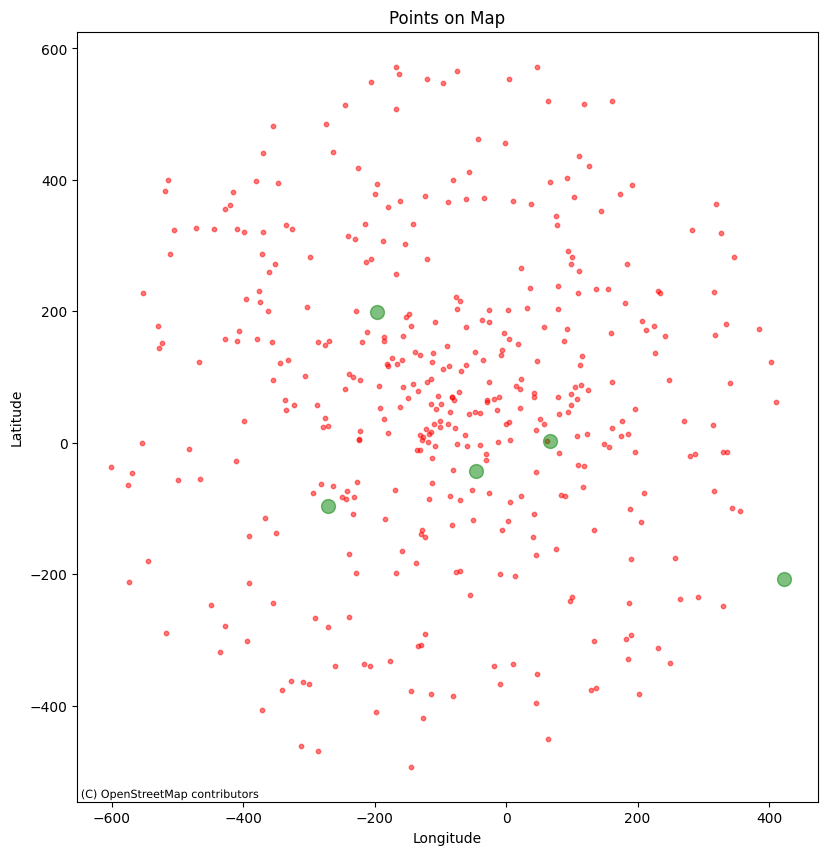

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

# Convert coordinates to GeoDataFrame
geometry = [Point(lon, lat) for lat, lon in coordinates]
gdf = gpd.GeoDataFrame(geometry=geometry)

# Set coordinate reference system to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Convert new points to GeoDataFrame
geometry_new = [Point(lon, lat) for lat, lon in center_latlon]
gdf_new = gpd.GeoDataFrame(geometry=geometry_new)

# Set coordinate reference system to WGS84 (EPSG:4326)
gdf_new.set_crs(epsg=4326, inplace=True)

# Plot the original points in red
ax = gdf.plot(figsize=(10, 10), color='red', alpha=0.5, markersize=10)

# Plot the new points in green
gdf_new.plot(ax=ax, color='green', alpha=0.5, markersize=100)

# Add basemap using OpenStreetMap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Points on Map')
plt.show()


The above map locates the 5 loactions where the facility is to be established.